In [5]:
!pip install contextualized-topic-models==2.2.0
!pip install pyldavis
!pip install PyPDF2

In [1]:
# I would avoid the Labelled LDA formulation unless you're sure that's what you want, because it makes a strong assumption about the correspondence between topics and categories in the classification problem.
# https://stackoverflow.com/questions/13555021/supervised-latent-dirichlet-allocation-for-document-classification
# Extracting statements from ESG reports
from io import StringIO
import pandas as pd
 
csv_str = """company,url
bank of america,https://www.responsibilityreports.com/Click/2522
barclays,https://www.responsibilityreports.com/Click/2297
canadian imperial bank,https://www.responsibilityreports.com/Click/1894
citigroup,https://www.responsibilityreports.com/Click/1515
eurobank,https://www.responsibilityreports.com/Click/3126
jpmorgan chase,https://www.responsibilityreports.com/Click/1278
keybank,https://www.responsibilityreports.com/Click/1599
laurentian bank of canada,https://www.responsibilityreports.com/Click/1918
national australia bank 1,https://www.responsibilityreports.com/Click/1555
national bank greece,https://www.responsibilityreports.com/Click/3104
pnc,https://www.responsibilityreports.com/Click/1829
standard chartered,https://www.responsibilityreports.com/Click/2781
tcf financial,https://www.responsibilityreports.com/Click/1669
wells fargo,https://www.responsibilityreports.com/Click/1904
ameriprise,https://www.responsibilityreports.com/Click/1784
janus henderson,https://www.responsibilityreports.com/Click/2813
t rowe price,https://www.responsibilityreports.com/Click/2044
lazard,https://www.responsibilityreports.com/Click/1429
capital one,https://www.responsibilityreports.com/Click/1640
goldman sachs,https://www.responsibilityreports.com/Click/1496"""
 
esg_df = pd.read_csv(StringIO(csv_str))
esg_df

,company,url
0,bank of america,https://www.responsibilityreports.com/Click/2522
1,barclays,https://www.responsibilityreports.com/Click/2297
2,canadian imperial bank,https://www.responsibilityreports.com/Click/1894
3,citigroup,https://www.responsibilityreports.com/Click/1515
4,eurobank,https://www.responsibilityreports.com/Click/3126
5,jpmorgan chase,https://www.responsibilityreports.com/Click/1278
6,keybank,https://www.responsibilityreports.com/Click/1599
7,laurentian bank of canada,https://www.responsibilityreports.com/Click/1918
8,national australia bank 1,https://www.responsibilityreports.com/Click/1555
9,national bank greece,https://www.responsibilityreports.com/Click/3104


In [2]:
import requests
from PyPDF2 import PdfFileReader
from io import BytesIO
 
def extract_content(url):
  response = requests.get(url)
  open_pdf_file = BytesIO(response.content)
  pdf = PdfFileReader(open_pdf_file, strict=False)  
  text = [pdf.getPage(i).extractText() for i in range(0, pdf.getNumPages())]
  return "\n".join(text)
 
esg_df['content'] = esg_df['url'].apply(extract_content)
esg_df.head()

,company,url,content
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...
1,barclays,https://www.responsibilityreports.com/Click/2297,Making a \n\nBarclays PLC\n Environmental Soci...
2,canadian imperial bank,https://www.responsibilityreports.com/Click/1894,1Sustainability Report\n 2020\n˜˚˛ Client˝foc...
3,citigroup,https://www.responsibilityreports.com/Click/1515,˜˚˛˝\n˙ˆ\n\n\nˇ\n\n\n\n\n˘ˆ\n˜˚˛˝˙ˆ\n˙˜˚˛˛˚˝˙ˆ...
4,eurobank,https://www.responsibilityreports.com/Click/3126,CORPORATE RESPONSIBILITY REPORT\n2018\n˜˚˛˝˙ˆ˚...


In [3]:
# clean pdf
import nltk
nltk.download('wordnet')
nltk.download('punkt')
import string
import re
 
def extract_statements(text):
  
  # remove non ASCII characters
  printable = set(string.printable)
  text = ''.join(filter(lambda x: x in printable, text))
  
  lines = []
  prev = ""
  for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with a dot.
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        # new paragraph
        lines.append(prev)
        prev = line
        
  # don't forget left-over paragraph
  lines.append(prev)
 
  # clean paragraphs from extra space, unwanted characters, urls, etc.
  # best effort clean up, consider a more versatile cleaner
  sentences = []
  
  for line in lines:
      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub(r'\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # ESG contains a lot of figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub(r'\s+', ' ', line)
      # remove multiple dot
      line = re.sub(r'\.+', '.', line)
      
      # split paragraphs into well defined sentences using nltk
      for part in nltk.sent_tokenize(line):
        sentences.append(str(part).strip())
 
  return sentences   
 
esg_df['statement'] = esg_df['content'].apply(extract_statements)
esg_df = esg_df.explode('statement').reset_index(drop=True)
esg_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,company,url,content,statement
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every..."
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d..."
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...


In [4]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

In [227]:
esg_df.statement

0        HUMAN CAPITAL MANAGEMENT REPORT Published Octo...
1        At Bank of America, we ask this question every...
2        It is at the core of how we live our values, d...
3        Deliver together Act responsibly Realize the p...
4        This is possible only because of our more than...
                               ...                        
11219    For information about some of the risks and im...
11220    Statements about the effects of the COVID-19 p...
11221                        2020 Goldman Sachs & Co. LLC.
11222                                 All rights reserved.
11223                                        TCFD Appendix
Name: statement, Length: 11224, dtype: object

In [235]:
esg_df = esg_df[esg_df.statement.astype(str).str.len()>50]


In [236]:
esg_df

,company,url,content,statement
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every..."
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d..."
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...
...,...,...,...,...
11215,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,This report contains forward-looking statement...
11217,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,Forward-looking statements are not historical ...
11218,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,It is possible that the rms actual results may...
11219,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,For information about some of the risks and im...


In [237]:
# esg_df[esg_df.statement.astype(str).str.len()>120]
# sp1 = WhiteSpacePreprocessing(esg_df[esg_df.statement.astype(str).str.len()>50].statement.values, stopwords_language='english',vocabulary_size=20000)
# preprocessed_documents1, unpreprocessed_corpus1, vocab1 = sp1.preprocess()
# len(preprocessed_documents1)

In [238]:
nltk.download('stopwords')

sp = WhiteSpacePreprocessing(esg_df.statement.values, stopwords_language='english',vocabulary_size=20000)
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [239]:
len(preprocessed_documents)

10381

In [240]:
# use climateBERT pretrained model
tp = TopicModelDataPreparation("climatebert/distilroberta-base-climate-f") # paraphrase-distilroberta-base-v1

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/climatebert_distilroberta-base-climate-f were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /root/.cache/torch/sentence_transformers/climatebert_distilroberta-base-climate-f and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You s

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

In [241]:
tp.vocab[:10]

['aa',
 'aaa',
 'aaip',
 'aairs',
 'aap',
 'aarn',
 'aaron',
 'ab',
 'abac',
 'abandoned']

In [242]:
# use LDA to tuning the number of topics
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=30, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [103810/103810]	Train Loss: 173.75618566408883	Time: 0:00:05.991953: : 10it [01:00,  6.07s/it]


In [243]:
ctm.get_topic_lists(10)

[['awareness',
  'plan',
  'experiences',
  'needs',
  'justice',
  'take',
  'allows',
  'encouraging',
  'technical',
  'goldman'],
 ['transition',
  'carbon',
  'clients',
  'economy',
  'solutions',
  'inclusive',
  'understand',
  'drive',
  'role',
  'growth'],
 ['report',
  'plc',
  'barclays',
  'disclosures',
  'see',
  'annual',
  'reporting',
  'management',
  'financial',
  'approach'],
 ['community',
  'women',
  'capital',
  'one',
  'support',
  'health',
  'million',
  'people',
  'diversity',
  'small'],
 ['barclays',
  'strategy',
  'plc',
  'esg',
  'risk',
  'governance',
  'focus',
  'disclosures',
  'committee',
  'related'],
 ['capital',
  'one',
  'community',
  'communities',
  'businesses',
  'help',
  'small',
  'health',
  'development',
  'million'],
 ['climate',
  'sustainable',
  'business',
  'investment',
  'clients',
  'governance',
  'change',
  'sustainability',
  'culture',
  'supporting'],
 ['community',
  'capital',
  'program',
  'one',
  'covid'

In [105]:
# # use climateBERT pretrained model
# tp2 = TopicModelDataPreparation("paraphrase-distilroberta-base-v1") # paraphrase-distilroberta-base-v1

# training_dataset2 = tp2.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
# # use LDA to tuning the number of topics
# ctm2 = CombinedTM(bow_size=len(tp2.vocab), contextual_size=768, n_components=30, num_epochs=10)
# ctm2.fit(training_dataset2) # run the model
# # ctm2.get_topic_lists(10)

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch: [10/10]	 Seen Samples: [110750/110750]	Train Loss: 111.28970120053259	Time: 0:00:05.473211: : 10it [00:55,  5.52s/it]


In [23]:
!pip install gensim

In [ ]:
# create word vector for ESG
# https://www.cfainstitute.org/en/research/esg-investing
# Environmental = ["climate", "carbon", "emissions", "air", "water", "pollution", "biodiversity", "deforestation", "energy", "efficiency", "waste"]
# Social = ["customer", "satisfaction", "data", "privacy", "gender", "diversity", "employee", "community", "relations", "human", "rights", "labor", "standards"]
# Governance = ["board", "audit", "bribery", "corruption", "compensation", "executive", "lobbying", "political", "whistleblower", "schemes"]

# SDG 17
# SDG1 = "No Poverty social, end poverty, poverty dimension, poverty, social protection, poor, unemployed person, poverty line, protection, cash benefit, extreme poverty, poor vulnerable, humanitarian, vulnerable"
# SDG2 = "Zero Hunger malnutrition, hunger, food producer, underweight, hunger malnutrition, undernutrition, famine, food insecurity, agricultural productivity, agricultural, extreme hunger, agriculture, prevalence undernourishment, nutritional need, food"
# SDG3 = "Good Health and Well-Being life expectancy, mental health, air pollution, medicine vaccine, infectious disease, good health, respiratory disease, reproductive health, mortality, healthcare, disease diabetes, disease, health coverage, health, maternal mortality, death preventable, cardiovascular disease"
# SDG4 = "Quality Education teacher, secondary school, proficiency level, primary school, inclusive, literacy, literacy numeracy, higher education, quality education, school, effective learn, vocational train, level proficiency, minimum proficiency, technical vocational"
# SDG5 = "Gender Equality domestic work, right, sexual violence, woman, girl, discrimination, reproductive health, managerial position, woman girl, marriage, woman representation, gender equality, gender parity, child marriage, gender"
# SDG6 = "Clean Water and Sanitation water sanitation, drink water, sanitation, basic drink, wastewater, water scarcity, hygiene, water, sanitation service, sanitation hygiene, supply freshwater, handwash facility, resource management, water stress"
# SDG7 = "Affordable and Clean Energy ’energy’, ’technology’, ’renewable energy’, ’infrastructure’, ’electricity’, ’cheap energy’, ’solar’, ’solar power’, ’wind power’, ’thermal power’, ’energy productivity’, ’energy efficiency’, ’greenhouse gases’, ’greenhouse’, ’fossil fuels’, ’pollution’, ’energy standards’, ’energy access’,’energy consumption’, ’access electricity’, ’without electricity’, ’fuel technology’,’fossil fuel’"
# SDG8 = "Decent Work and Economic Growth ’labor’, ’employment’, ’gdp’, ’job’, ’unemployed’, ’economic growth’, ’productivity’, ’job creation’, ’slavery’, ’forced labor’, ’labor force’, ’women participation’, ’labor organization’,’human right’, ’informal employment’, ’growth rate’, ’labour productivity’,’decent work’,’secure work’,’global economic’,’gender pay’,’crisis level’, ’rate real’, ’decent work’,’education employment’,’slavery human’, ’child labour’, ’youth employment’"
# SDG9 = "Industry, Innovation and Infrastructure ’research development’, ’development’, ’industry’, ’infrastructure’, ’transport’, ’technological progress’, ’communication technology’, ’sustainable development’, ’sustainable industries’, ’innovation’, ’entrepreneurship’, ’access information’,’access internet’, ’material footprint’, ’develop country’, ’least develop’, ’economic infrastructure’,’infrastructure support’,’global manufacture’, ’scientific research’, ’resilient infrastructure’, ’research innovation’"
# SDG10 = "Reduced Inequalities ’income’, ’population’, ’income inequality’, ’economic inclusion’, ’safe migration’, ’economic inequality’, ’reduce inequality’, ’wealth share’, ’indigenous rights’, ’migrant worker’, ’migrant’, ’official development’, ’income inequality’,’migration mobility’,’global wealth’, ’least develop’ , ’development assistance’"
# SDG11 = "Sustainable Cities and Communities ’city’, ’urban’, ’urban population’,’public’, ’disability’, ’disaster’, ’sustainable city’, ’affordable housing’, ’housing access’, ’resilient societies’, ’public transport’, ’public spaces’, ’urban planning’, ’inclusive’, ’business opportunities’, ’sustainable development’, ’person disability’, ’green public’, ’sustainable resilient’,’sustainable urbanization’,’population convenient’, ’convenient access’"
# SDG12 = "Responsible Consumption and Production ’responsible consumption’, ’sustainable development’, ’resources’, ’consumption’, ’production’, ’development’, ’reduce waste’, ’efficient’, ’efficient economy’, ’energy consumption’, ’energy efficient’, ’supporting developing’, ’material footprint’, ’natural resource’,’recycle’,’sustainable consumption’,’domestic material’,’consumption production’,’food waste’"
# SDG13 = "Climate Action ’climate’, ’develop’, ’disaster’, ’local’, ’emissions reductions’, ’global warm’,’climate change’, ’climate system’, ’greenhouse gas’, ’emissions’, ’co2 emissions’, ’low carbon’, ’disaster risk’, ’sustainable management’, ’natural resource’, ’sea levels’, ’sustainable energy’,’paris agreement’, ’sustainable energy’, ’climate relate’,’green climate’,’disaster risk"
# SDG14 = "Life Below Water ’marine’, ’ocean’, ’fish’, ’sea’, ’water’, ’fishery’, ’overfishing’, ’coastal biodiversity’, ’coastal ecosystems’, ’ocean resources’ ’marine biodiversity’, ’fish stocks’, ’marine pollution’, ’ocean acidification’, ’depleted fisheries’, ’unregulated fish’,’fish stock’, ’fishery management’,’marine coastal’,’fishery subsidy’,’conservation sustainable’, ’marine technology"
# SDG15 = "Life on Land land degradation, terrestrial freshwater, ecosystem, deforestation, specie animal, forest management, biodiversity, conservation, protect area, forest, terrestrial, species, wildlife, protect, agriculture, land, area"
# SDG17 = "Peace, Justice and Strong Institutions law, human right, right violation, insecurity, institution, violence, exploitation, global governance, transparency, rule, corruption bribery, access justice, corruption, justice, peace, conflict violence, international, victim human, conflict"




In [244]:
data2 = []
for element in ctm.get_topic_lists(30):
  data2.append(' '.join(element))
data2

['awareness plan experiences needs justice take allows encouraging technical goldman use experts feel past efforts capacity digital governments protect contribute levels racial gives strive prospects goal better role sachs good',
 'transition carbon clients economy solutions inclusive understand drive role growth markets us way initiatives client improve rm believe aiming sustainable resilience advance developing positive capabilities deliver critical renewable reduce tools',
 'report plc barclays disclosures see annual reporting management financial approach information esg governance corporate principles social general environmental gri sustainability pages standards performance strategy material disclosure areas assurance banks board',
 'community women capital one support health million people diversity small best employees program programs including work year workplaces veterans businesses leave fortune top families help commitment care associates career color',
 'barclays strateg

In [198]:
# data2 = []
# for element in ctm2.get_topic_lists(30):
#   data2.append(' '.join(element))
# data2

In [245]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
data1 = ["Environmental, Conservation of the natural world, Climate change and carbon emissions, Air and water pollution, Biodiversity, Deforestation, Energy efficiency, Waste management, Water scarcity",
        "Social, Consideration of people & relationships, Customer satisfaction, Data protection and privacy, Gender and diversity, Employee engagement, Community relations, Human rights, Labor standards",
        "Governance, Standards for running a company, Board composition, Audit committee structure, Bribery and corruption, Executive compensation, Lobbying, Political contributions, Whistleblower schemes"]

data = data1 + data2
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=80)
similar_doc = model.docvecs.most_similar('0')
print(similar_doc)

[('11', 0.9935979843139648), ('9', 0.9924867153167725), ('4', 0.9914678931236267), ('21', 0.990496814250946), ('7', 0.9900330901145935), ('19', 0.9898356199264526), ('5', 0.9897946119308472), ('23', 0.9897936582565308), ('12', 0.9887877106666565), ('1', 0.988619863986969)]


In [246]:
n=3 # number of topics
category = []
for i in range(n):
  similar_doc = model.docvecs.most_similar(str(i))
  for element in similar_doc:
    if element[0] not in ['0','1','2']:
      category.append([i, int(element[0]), element[1]])

In [247]:
sorted_category = sorted(category, key=lambda x: x[2], reverse=True)
sorted_category

[[1, 23, 0.9967954158782959],
 [1, 5, 0.9960578680038452],
 [1, 32, 0.9958510994911194],
 [1, 4, 0.9951613545417786],
 [1, 25, 0.995036244392395],
 [1, 12, 0.9950171709060669],
 [1, 16, 0.9943683743476868],
 [1, 9, 0.9938914179801941],
 [1, 7, 0.9938040375709534],
 [1, 21, 0.993600070476532],
 [0, 11, 0.9935979843139648],
 [0, 9, 0.9924867153167725],
 [0, 4, 0.9914678931236267],
 [0, 21, 0.990496814250946],
 [0, 7, 0.9900330901145935],
 [0, 19, 0.9898356199264526],
 [0, 5, 0.9897946119308472],
 [0, 23, 0.9897936582565308],
 [0, 12, 0.9887877106666565],
 [2, 28, 0.882378101348877],
 [2, 9, 0.8750995397567749],
 [2, 23, 0.8703368306159973],
 [2, 21, 0.8702959418296814],
 [2, 5, 0.8702335357666016],
 [2, 17, 0.8693901300430298],
 [2, 8, 0.8691553473472595],
 [2, 11, 0.8677628636360168]]

In [248]:
# mapping to ESG
assign_category = []
temp = []
for x in sorted_category:
  if x[1] not in temp:
    assign_category.append([x[0],x[1]])
    temp.append(x[1])


In [249]:
assign_category

[[1, 23],
 [1, 5],
 [1, 32],
 [1, 4],
 [1, 25],
 [1, 12],
 [1, 16],
 [1, 9],
 [1, 7],
 [1, 21],
 [0, 11],
 [0, 19],
 [2, 28],
 [2, 17],
 [2, 8]]

In [154]:
# Environmental = "Environmental, Conservation of the natural world, Climate change and carbon emissions, Air and water pollution, Biodiversity, Deforestation, Energy efficiency, Waste management, Water scarcity"
# Social = "Social, Consideration of people & relationships, Customer satisfaction, Data protection and privacy, Gender and diversity, Employee engagement, Community relations, Human rights, Labor standards"
# Governance = "Governance, Standards for running a company, Board composition, Audit committee structure, Bribery and corruption, Executive compensation, Lobbying, Political contributions, Whistleblower schemes"

# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'\w+')
# environmental_token = tokenizer.tokenize(Environmental.lower())
# social_token = tokenizer.tokenize(Social.lower())
# governance_token = tokenizer.tokenize(Governance.lower())



In [160]:
# new_vector = model.infer_vector(environmental_token)
# sims = model.docvecs.most_similar([new_vector])
# sims

In [186]:
# category = []
# n = 3 # number of topics
# for i in range(n,len(data)):
  
#   similar_doc = model.docvecs.most_similar(str(i))
#   print("i is: ", i, "similar doc", similar_doc)
#   for x in similar_doc:
#     if x[0] == '0':
#       category.append([0,i])
#       break
#     if x[0] == '1':
#       category.append([1,i])
#       break
#     if x[0] == '2':
#       category.append([2,i])
#       break

In [250]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=20)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [20/20]: : 20it [01:36,  4.85s/it]


In [251]:
# take a ocument and see which topic has been assigned to it
topics_predictions = ctm.get_thetas(training_dataset, n_samples=20) # get all the topic predictions
topics_predictions

Sampling: [20/20]: : 20it [01:39,  4.96s/it]


array([[0.00597579, 0.03647709, 0.0254318 , ..., 0.00290581, 0.00389621,
        0.07179415],
       [0.03356862, 0.01951773, 0.00544763, ..., 0.07226021, 0.0407792 ,
        0.00993129],
       [0.02427211, 0.01688069, 0.00801547, ..., 0.02882356, 0.03359598,
        0.00650976],
       ...,
       [0.00715279, 0.00709427, 0.01344362, ..., 0.04263522, 0.02173656,
        0.00595962],
       [0.00173038, 0.00088796, 0.18031427, ..., 0.01269341, 0.05129462,
        0.03728088],
       [0.01477542, 0.03137037, 0.02189867, ..., 0.01331769, 0.01561066,
        0.01281845]])

In [201]:
# import numpy as np
# topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document
# ctm.get_topic_lists(5)[topic_number]




In [252]:
# save the model
ctm.save(models_dir="./")
# let's remove the trained model
del ctm
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, num_epochs=100, n_components=5)

# # and load
# ctm.load("/content/contextualized_topic_model_nc_50_tpm_0.0_tpv_0.98_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",epoch=19)
# ctm.get_topic_lists(5)       

In [253]:
esg_df["probabilities"] = topics_predictions.tolist()
esg_df

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [ipykernel_launcher.py:1]


,company,url,content,statement,probabilities
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...,"[0.005975789250805974, 0.03647709160577506, 0...."
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every...","[0.033568624104373154, 0.019517732538224662, 0..."
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d...","[0.02427211166941561, 0.016880689654499292, 0...."
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...,"[0.0034344305386184715, 0.023137742979452015, ..."
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...,"[0.01955989279667847, 0.013041535185766406, 0...."
...,...,...,...,...,...
11215,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,This report contains forward-looking statement...,"[0.009941503375011962, 0.007810943055665121, 0..."
11217,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,Forward-looking statements are not historical ...,"[0.018152790964813904, 0.011224769230466336, 0..."
11218,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,It is possible that the rms actual results may...,"[0.007152794594003353, 0.007094266462081578, 0..."
11219,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,For information about some of the risks and im...,"[0.0017303821572568268, 0.0008879600514774211,..."


In [259]:
assign_category_second_dim = []
for element in assign_category:
  assign_category_second_dim.append(element[1])
n=3 #number of topics
for i in range(n,n+30): # 30 this number needs to be modified
  if i not in assign_category_second_dim:
    assign_category.append([3,i])

for element in assign_category:
  element[1] = element[1]-3

assign_category

[[1, 20],
 [1, 2],
 [1, 29],
 [1, 1],
 [1, 22],
 [1, 9],
 [1, 13],
 [1, 6],
 [1, 4],
 [1, 18],
 [0, 8],
 [0, 16],
 [2, 25],
 [2, 14],
 [2, 5],
 [3, 0],
 [3, 3],
 [3, 7],
 [3, 10],
 [3, 11],
 [3, 12],
 [3, 15],
 [3, 17],
 [3, 19],
 [3, 21],
 [3, 23],
 [3, 24],
 [3, 26],
 [3, 27],
 [3, 28]]

In [265]:
dictionary_assign_category = {}
for element in assign_category:
  if element[0] == 0:
    label = "E"
  if element[0] == 1:
    label = "S"
  if element[0] == 2:
    label = "G"
  if element[0] == 3:
    label = "Other"
  dictionary_assign_category[element[1]] = label
dictionary_assign_category

{20: 'S',
 2: 'S',
 29: 'S',
 1: 'S',
 22: 'S',
 9: 'S',
 13: 'S',
 6: 'S',
 4: 'S',
 18: 'S',
 8: 'E',
 16: 'E',
 25: 'G',
 14: 'G',
 5: 'G',
 0: 'Other',
 3: 'Other',
 7: 'Other',
 10: 'Other',
 11: 'Other',
 12: 'Other',
 15: 'Other',
 17: 'Other',
 19: 'Other',
 21: 'Other',
 23: 'Other',
 24: 'Other',
 26: 'Other',
 27: 'Other',
 28: 'Other'}

In [266]:
import numpy as np
df = esg_df.copy()
df['id'] = df['probabilities'].apply(lambda x: np.argmax(x))
df['probability'] = df['probabilities'].apply(lambda x: np.max(x))
df

,company,url,content,statement,probabilities,id,probability
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...,"[0.005975789250805974, 0.03647709160577506, 0....",16,0.256460
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every...","[0.033568624104373154, 0.019517732538224662, 0...",17,0.091603
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d...","[0.02427211166941561, 0.016880689654499292, 0....",15,0.135662
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...,"[0.0034344305386184715, 0.023137742979452015, ...",6,0.284138
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...,"[0.01955989279667847, 0.013041535185766406, 0....",19,0.141000
...,...,...,...,...,...,...,...
11215,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,This report contains forward-looking statement...,"[0.009941503375011962, 0.007810943055665121, 0...",28,0.127562
11217,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,Forward-looking statements are not historical ...,"[0.018152790964813904, 0.011224769230466336, 0...",23,0.160135
11218,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,It is possible that the rms actual results may...,"[0.007152794594003353, 0.007094266462081578, 0...",23,0.205014
11219,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,For information about some of the risks and im...,"[0.0017303821572568268, 0.0008879600514774211,...",4,0.318934


In [268]:
df["id"] = df["id"].map(dictionary_assign_category)
df

,company,url,content,statement,probabilities,id,probability
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...,"[0.005975789250805974, 0.03647709160577506, 0....",E,0.256460
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every...","[0.033568624104373154, 0.019517732538224662, 0...",Other,0.091603
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d...","[0.02427211166941561, 0.016880689654499292, 0....",Other,0.135662
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...,"[0.0034344305386184715, 0.023137742979452015, ...",S,0.284138
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...,"[0.01955989279667847, 0.013041535185766406, 0....",Other,0.141000
...,...,...,...,...,...,...,...
11215,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,This report contains forward-looking statement...,"[0.009941503375011962, 0.007810943055665121, 0...",Other,0.127562
11217,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,Forward-looking statements are not historical ...,"[0.018152790964813904, 0.011224769230466336, 0...",Other,0.160135
11218,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,It is possible that the rms actual results may...,"[0.007152794594003353, 0.007094266462081578, 0...",Other,0.205014
11219,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,For information about some of the risks and im...,"[0.0017303821572568268, 0.0008879600514774211,...",S,0.318934


In [272]:
df.sort_values(['company','probability'], ascending=False).groupby('company').head(1)

,company,url,content,statement,probabilities,id,probability
7668,wells fargo,https://www.responsibilityreports.com/Click/1904,12019Corporate Responsibility Highlights\n\n\n...,We are committed to creating a diverse and inc...,"[0.0003537962445989251, 0.0006347103888401761,...",Other,0.581458
7411,tcf financial,https://www.responsibilityreports.com/Click/1669,2019 TCF Center Annual Report\nCorporate Socia...,Meet the Hardest Working Team in Show Business...,"[0.009327307758212555, 0.016836468857945874, 0...",G,0.372829
8062,t rowe price,https://www.responsibilityreports.com/Click/2044,Issued \n April 2020\nSUSTAINABLE INVESTING\nE...,"Together, these teams help our investors ident...","[0.0034565595080493948, 0.059969967126380655, ...",E,0.484227
7296,standard chartered,https://www.responsibilityreports.com/Click/2781,Sustainab˜lity Summary 2020\nª Supporting our ...,"We will develop and consult with shareholders,...","[0.0001404188464221079, 0.0008054649922996759,...",S,0.669631
7092,pnc,https://www.responsibilityreports.com/Click/1829,THE PNC FINANCIAL SERVICES GROUP \nŁ CORPORATE...,Description of approach to incorporation of en...,"[0.0003531658558131312, 0.00040176652855734575...",S,0.508250
6124,national bank greece,https://www.responsibilityreports.com/Click/3104,Sustainability \nReport\n2019\n\n\nSustainabil...,Directors remuneration Board Directors remuner...,"[0.00023833656596252694, 0.0001710369913780596...",S,0.559079
5310,national australia bank 1,https://www.responsibilityreports.com/Click/1555,SUSTAINABILITY\nREPORT\n 2020˜˚˛˝˙ˆ˚˛˚ˇ˝˚ˆ˝˝˛\...,32 Supporting customers Colleague capability a...,"[1.409198730470962e-05, 9.654051991674351e-05,...",S,0.683325
8852,lazard,https://www.responsibilityreports.com/Click/1429,2019 CORPORATE SUSTAINABILITY REPORT | \n12019...,Stakeholder Engagement Highlights SHAREHOLDERS...,"[0.00020723552479466888, 0.0016369337274227292...",S,0.761889
4197,laurentian bank of canada,https://www.responsibilityreports.com/Click/1918,03/21\n\n2020 Social Responsibility Report \n2...,/21 2020 Social Responsibility Report 2TABLE O...,"[0.0007988847995875403, 0.0015568604576401412,...",S,0.419208
3968,keybank,https://www.responsibilityreports.com/Click/1599,KeyCorp \n2019 Corporate Responsibility Repor...,"Greg Jones, Chief Diversity, Equity, and Inclu...","[0.0003853447124129161, 0.0008208426035707817,...",Other,0.531806


In [277]:
# "How much more does company X focus on the wellbeing of their employees compare to company Y?"
esg_group = df.copy()
esg_group = pd.pivot_table(
  esg_group, 
  values='probability', 
  index='company',
  columns=['id'])
esg_group

id,E,G,Other,S
company,,,,
ameriprise,0.194885,0.150421,0.145987,0.226657
bank of america,0.155174,0.258290,0.178705,0.169130
barclays,0.170087,0.165288,0.176900,0.269469
canadian imperial bank,0.183540,0.159308,0.139085,0.204467
capital one,0.162704,0.208560,0.157964,0.159625
citigroup,0.073557,0.114794,0.169328,0.195113
eurobank,0.126012,0.147634,0.123163,0.162997
goldman sachs,0.229756,0.184936,0.142503,0.222668
janus henderson,0.187251,0.191753,0.135549,0.171891


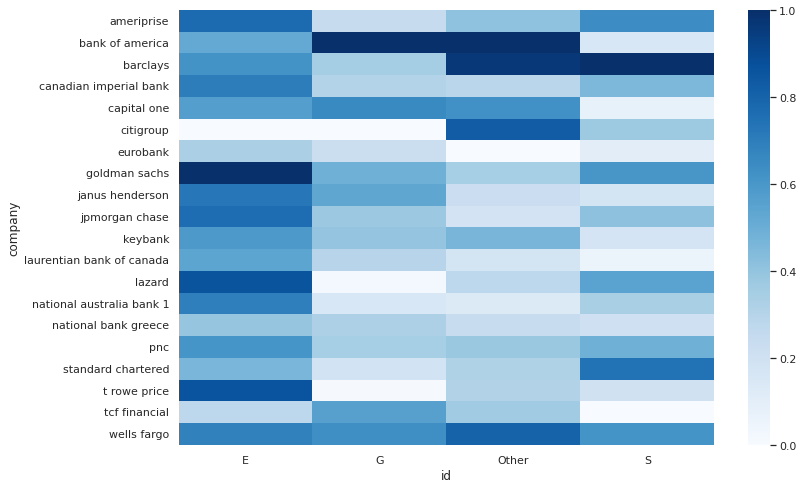

In [278]:
# scale topic frequency between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
esg_focus = pd.DataFrame(scaler.fit_transform(esg_group), columns=esg_group.columns)
esg_focus.index = esg_group.index
 
# plot heatmap, showing main area of focus for each company across topics we learned
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(esg_focus, annot=False, cmap='Blues')
plt.show()

In [287]:
# manually check if it is corrected classified
df.sort_values(['company','probability'], ascending=False).groupby(['company','id']).head(3).iloc[2,:].statement

'~$26bProvided ~$26 billion in nancing to sustainable businesses and projects to accelerate the transition to a low-carbon economy; bringing our cumulative total to ~$49 billion of our $200 billion commitment15Expanded the scope of Wells Fargo Innovation Incubator (IN2) to include sustainable agriculture and housing solutions, adding 15 new companies to the program42m Exceeded 42 million square feet of LEED certied projects and enhanced building eciency with LED lighting upgrades across 400 sites and almost 4,000 programmable thermostats across 900 sitesIntend to meet 100% of our global electricity needs with renewable energy1 and entered into our largest long-term renewable energy purchase to dateWells Fargo Asset Management joined the Climate Action 100+, a coalition of institutional investors that seeks greater company disclosure around climate change risk and company strategy alignment with the Paris Agreement 1919Since 2003, Wells Fargo has delighted golf fans, Wells Fargo employe

In [288]:
csr_summary = df.groupby(['company','id']).mean().reset_index()
csr_summary["count"] = df.groupby(['company','id']).count().reset_index()["statement"].values
csr_summary = csr_summary.rename(columns={"probability": "esg", "company":"organisation"})
csr_summary

,organisation,id,esg,count
0,ameriprise,E,0.194885,14
1,ameriprise,G,0.150421,11
2,ameriprise,Other,0.145987,41
3,ameriprise,S,0.226657,18
4,bank of america,E,0.155174,16
...,...,...,...,...
75,tcf financial,S,0.150279,42
76,wells fargo,E,0.181211,6
77,wells fargo,G,0.206154,8
78,wells fargo,Other,0.167749,38


In [289]:
# normalization
from scipy.stats import percentileofscore

esg_scores = csr_summary.groupby(['id'])['esg'].agg(list)
esg_scores_norm = pd.DataFrame(esg_scores).rename({'esg': 'esg_dist'}, axis=1)
esg_norm = csr_summary.merge(esg_scores_norm, left_on=['id'], right_on=['id'])
def norm(score, dist):
  return percentileofscore(dist, score)
 
esg_norm['esg'] = esg_norm.apply(lambda x: norm(x.esg, x.esg_dist), axis=1)
esg_norm['confidence'] = pd.cut(esg_norm['count'], 3, labels=["poor", "medium", "high"])
 
esg_norm = esg_norm[['id', 'organisation', 'esg', 'confidence']]
esg_norm

,id,organisation,esg,confidence
0,E,ameriprise,85.0,poor
1,E,bank of america,30.0,poor
2,E,barclays,55.0,poor
3,E,canadian imperial bank,70.0,poor
4,E,capital one,40.0,poor
...,...,...,...,...
75,S,pnc,70.0,poor
76,S,standard chartered,95.0,poor
77,S,t rowe price,40.0,poor
78,S,tcf financial,5.0,poor


In [290]:
esg_norm[esg_norm.organisation=="ameriprise"]

,id,organisation,esg,confidence
0,E,ameriprise,85.0,poor
20,G,ameriprise,35.0,poor
40,Other,ameriprise,70.0,poor
60,S,ameriprise,90.0,poor


In [294]:
# represent companies ESG focus across the E, S and G using a simple bar chart.
esg_csr_data = esg_norm.groupby(["organisation","id"])["esg"].mean().reset_index()
esg_csr_data["esg"] = esg_csr_data["esg"]/3
esg_csr_data = esg_csr_data.pivot(index='organisation', columns='id', values='esg')
esg_csr_data

id,E,G,Other,S
organisation,,,,
ameriprise,28.333333,11.666667,23.333333,30.000000
bank of america,10.000000,33.333333,33.333333,8.333333
barclays,18.333333,20.000000,31.666667,33.333333
canadian imperial bank,23.333333,15.000000,13.333333,21.666667
capital one,13.333333,31.666667,26.666667,5.000000
citigroup,1.666667,1.666667,30.000000,18.333333
eurobank,5.000000,10.000000,1.666667,6.666667
goldman sachs,33.333333,25.000000,18.333333,26.666667
janus henderson,25.000000,26.666667,8.333333,11.666667


In [296]:
esg_csr_data.columns

Index(['E', 'G', 'Other', 'S'], dtype='object', name='id')

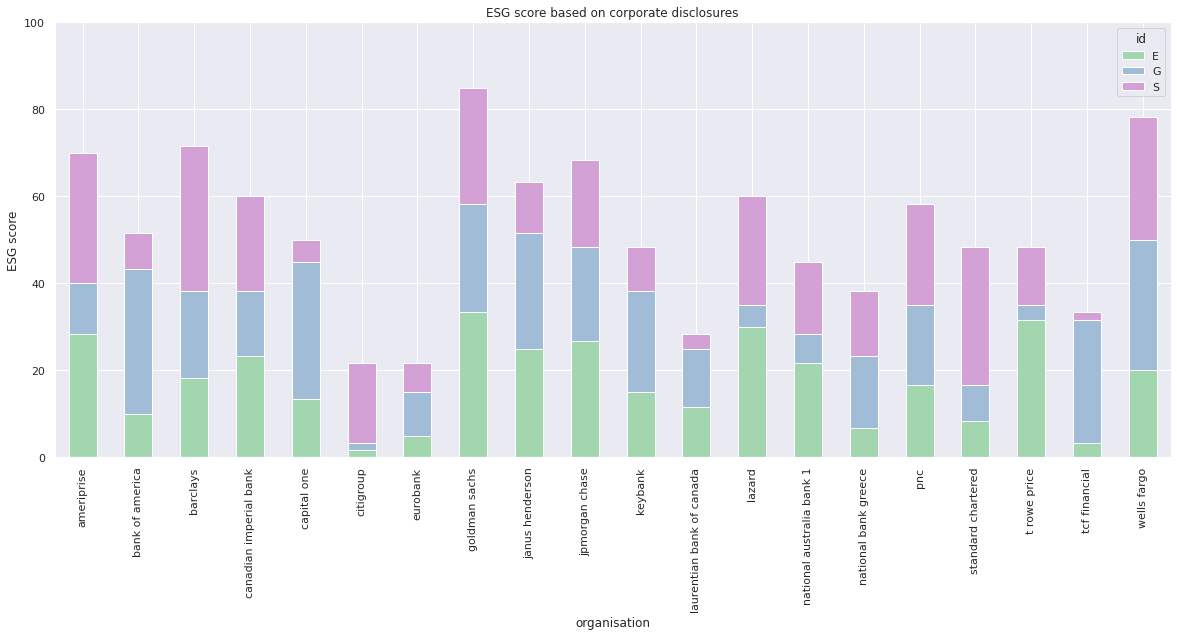

In [297]:
esg_csr_data[['E', 'G', 'S']].plot.bar(
  rot=90, 
  stacked=True, 
  color={"E": "#A1D6AF", "S": "#D3A1D6", "G": "#A1BCD6"},
  title='ESG score based on corporate disclosures',
  ylabel='ESG score',
  ylim=[0, 100],
  figsize=(20,8)
)

,company,url,content,statement,probabilities,id,probability
0,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,HUMAN CAPITAL MANAGEMENT REPORT Published Octo...,"[0.005975789250805974, 0.03647709160577506, 0....",E,0.256460
1,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"At Bank of America, we ask this question every...","[0.033568624104373154, 0.019517732538224662, 0...",Other,0.091603
2,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,"It is at the core of how we live our values, d...","[0.02427211166941561, 0.016880689654499292, 0....",Other,0.135662
3,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,Deliver together Act responsibly Realize the p...,"[0.0034344305386184715, 0.023137742979452015, ...",S,0.284138
4,bank of america,https://www.responsibilityreports.com/Click/2522,2020 HUMAN CAPITAL MANAGEMENT REPORT \nPublish...,This is possible only because of our more than...,"[0.01955989279667847, 0.013041535185766406, 0....",Other,0.141000
...,...,...,...,...,...,...,...
11215,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,This report contains forward-looking statement...,"[0.009941503375011962, 0.007810943055665121, 0...",Other,0.127562
11217,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,Forward-looking statements are not historical ...,"[0.018152790964813904, 0.011224769230466336, 0...",Other,0.160135
11218,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,It is possible that the rms actual results may...,"[0.007152794594003353, 0.007094266462081578, 0...",Other,0.205014
11219,goldman sachs,https://www.responsibilityreports.com/Click/1496,Goldman Sachs 2019 Sustainability Report\nSUST...,For information about some of the risks and im...,"[0.0017303821572568268, 0.0008879600514774211,...",S,0.318934
